Kaggle Dataset Link : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
import scipy
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from collections import Counter
from imblearn.combine import SMOTEENN
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv(r"Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#check missing values
df.isnull().sum().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
#Convert TotalCharges from  object to numeric
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"],errors="coerce")

In [7]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [8]:
#drop customer id its not of any used
df.drop("customerID",axis=1,inplace=True)

In [9]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# EDA

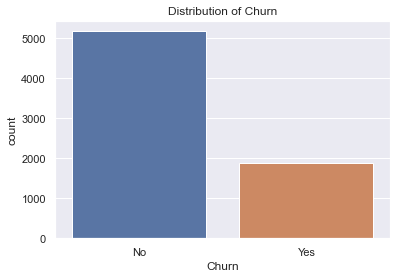

In [10]:
#check the distibution of churn class
sns.countplot(data=df,x="Churn")
plt.title("Distribution of Churn")
plt.show()

In [11]:
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [12]:
#perentage of each class sample distribution
print("Customer Churn : {}%".format(np.round((len(df[df["Churn"]=="Yes"])/len(df)*100),decimals=2)))
print("Customer Not Churn : {}%".format(np.round((len(df[df["Churn"]=="No"])/len(df)*100),decimals=2)))

Customer Churn : 26.54%
Customer Not Churn : 73.46%


Since our dataset is highly imbalance we need to balance before fitting it into model

In [13]:
#how much loss we have because of customer churn
churn_customers=df[df["Churn"]=="Yes"]
loss=churn_customers["TotalCharges"].sum()
total_revenue=df["TotalCharges"].sum()
print("We have lost arround ${} due to customer churn".format(loss))
print("We have lost arround {} percentage of revengue due to customer churn".format(np.round(loss/total_revenue*100,decimals=2)))

We have lost arround $2862926.9 due to customer churn
We have lost arround 17.83 percentage of revengue due to customer churn


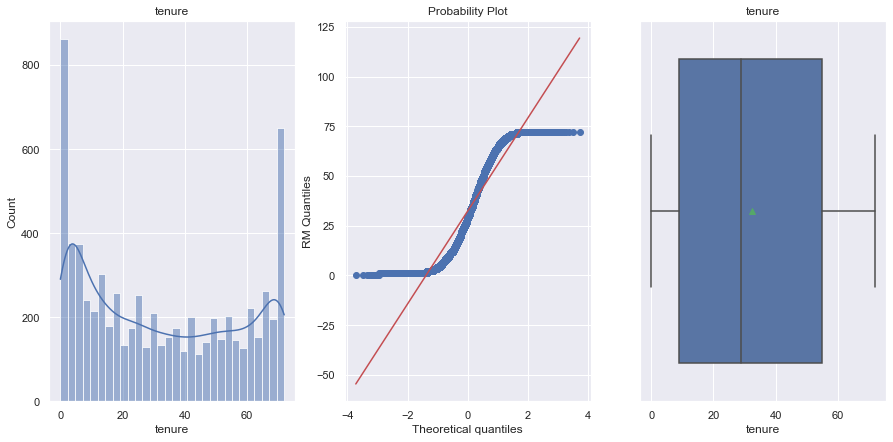

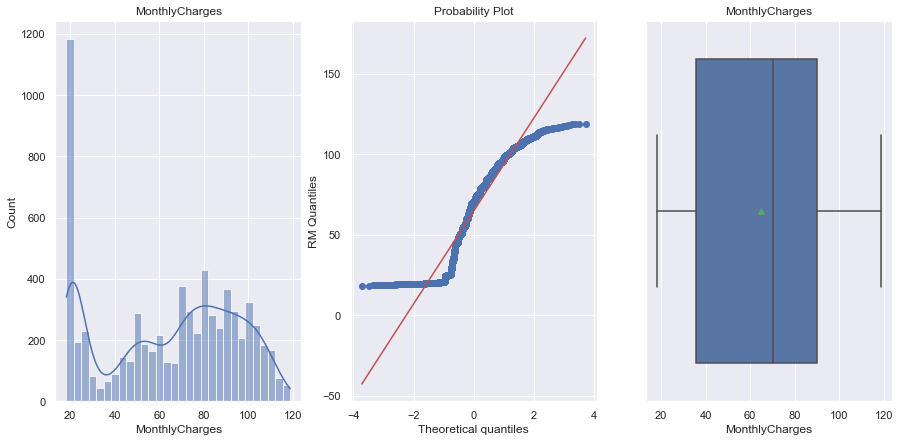

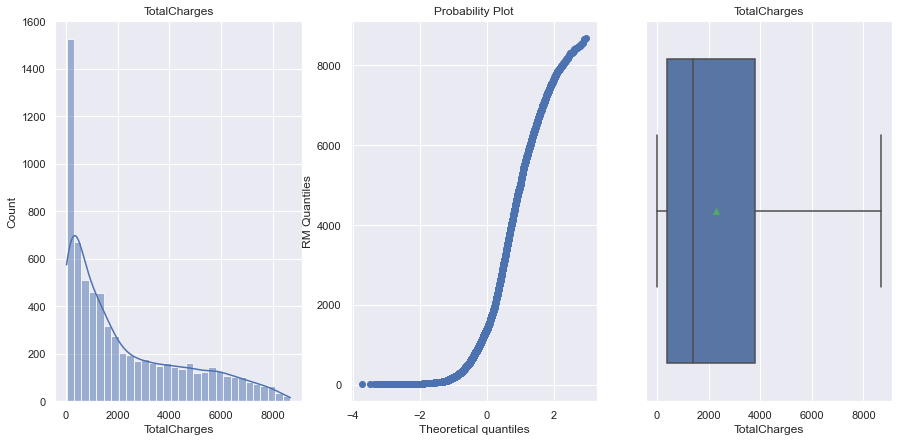

In [14]:
#Plotting Numerical features with probability distribution and checking outlier
for col in df.select_dtypes(include=["int64","float64"]):
    if(col!="SeniorCitizen"):
        plt.figure(figsize=(15,7))
        plt.subplot(1,3,1)
        plt.title(col)
        sns.histplot(df[col],bins=30,kde=True)
        
        plt.subplot(1,3,2)
        plt.title(col)        
        scipy.stats.probplot(df[col],dist="norm",plot=plt)
        plt.ylabel("RM Quantiles")
        plt.subplot(1,3,3)
        plt.title(col)
        sns.boxplot(x=df[col],showmeans=True)

after plotting histogram , probability distribution and boxplot to find numerical feature are normally distribution and dataset has no outlier, so we can need to do any kind of outlier treatment.

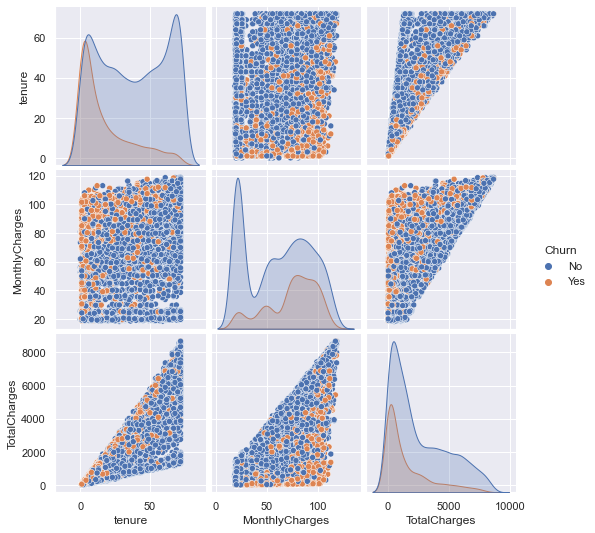

In [15]:
sns.pairplot(df.drop(columns="SeniorCitizen"),hue="Churn",kind="scatter")
plt.show()

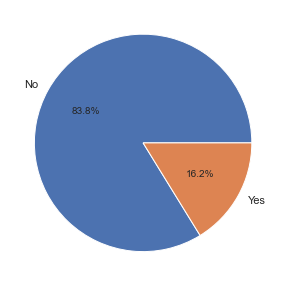

In [16]:
#pie chart to count senior citizen
plt.figure(figsize=(10,5))
plt.pie(df["SeniorCitizen"].value_counts(),autopct="%.1f%%",labels=["No","Yes"])
plt.show()

16.2% of the customers are senior citizen and remaining 83.8% of customers are young

# Univariate Analysis

<Figure size 432x288 with 0 Axes>

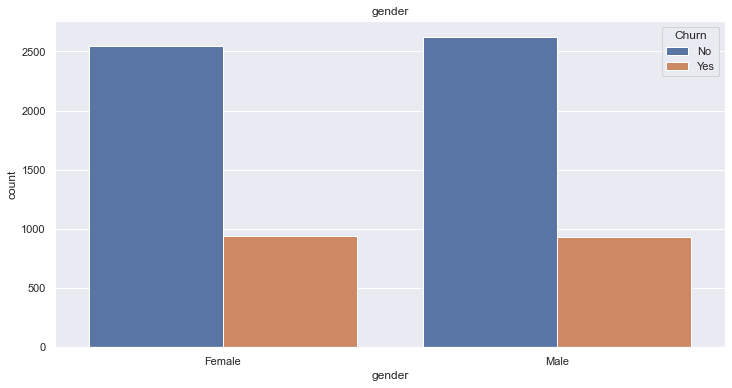

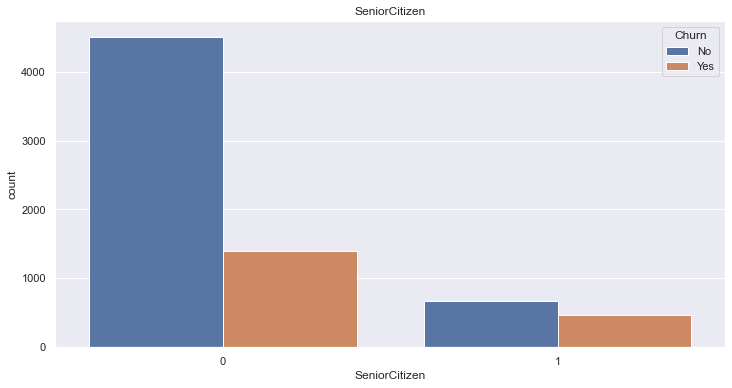

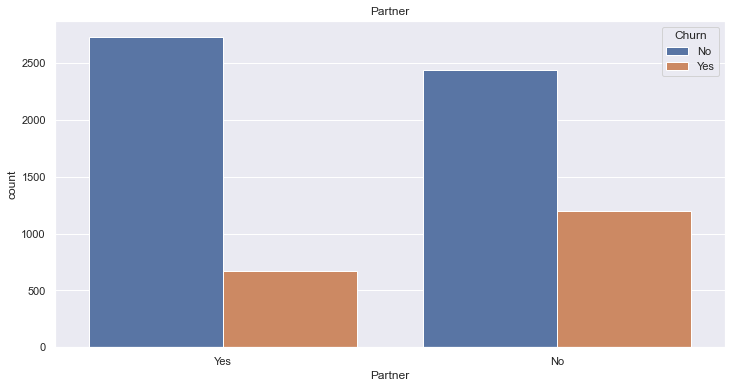

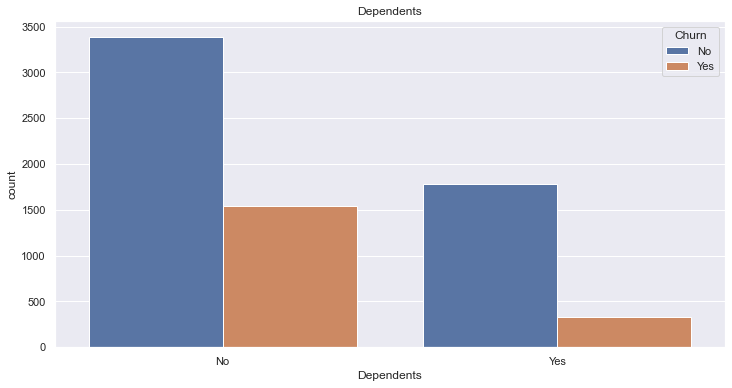

<Figure size 432x288 with 0 Axes>

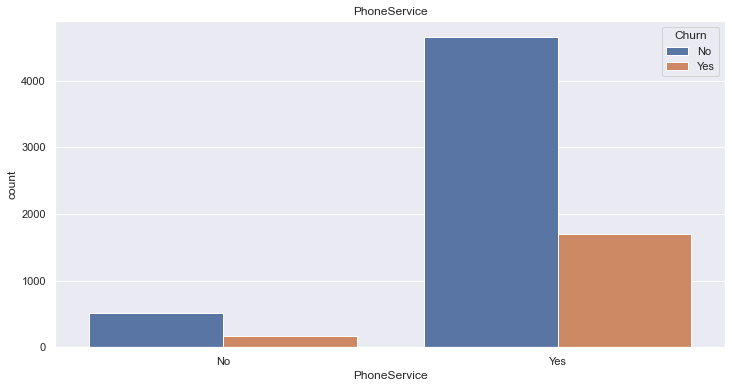

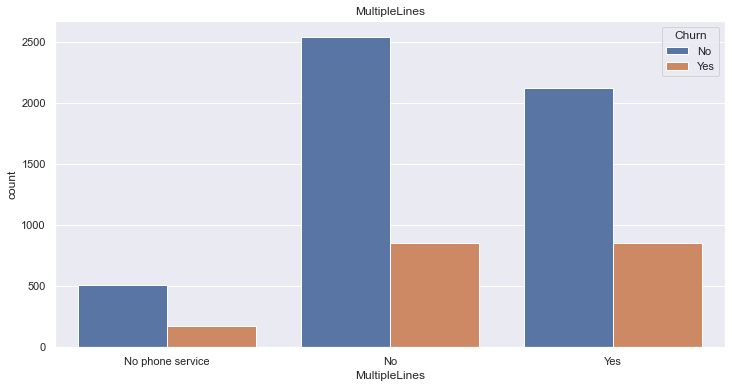

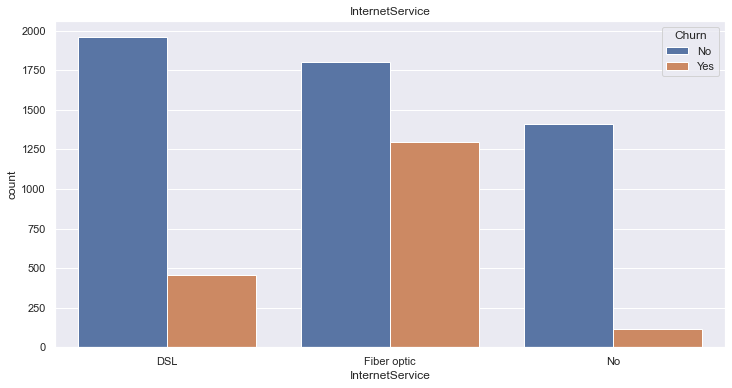

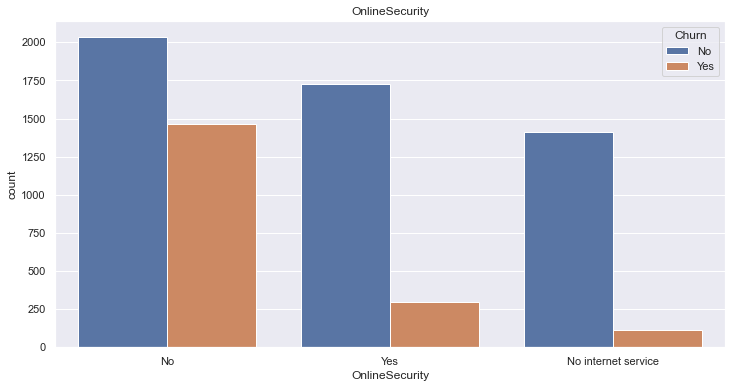

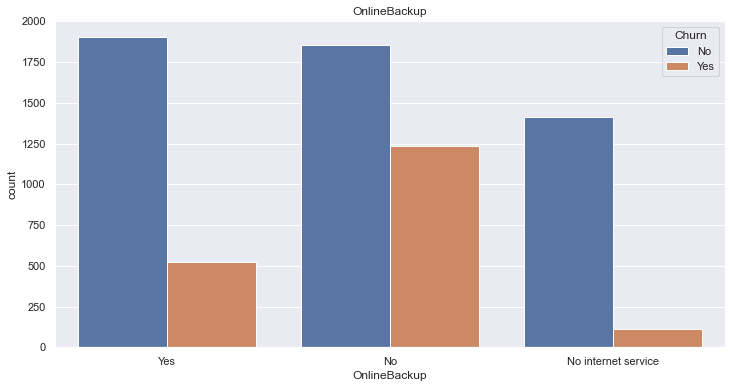

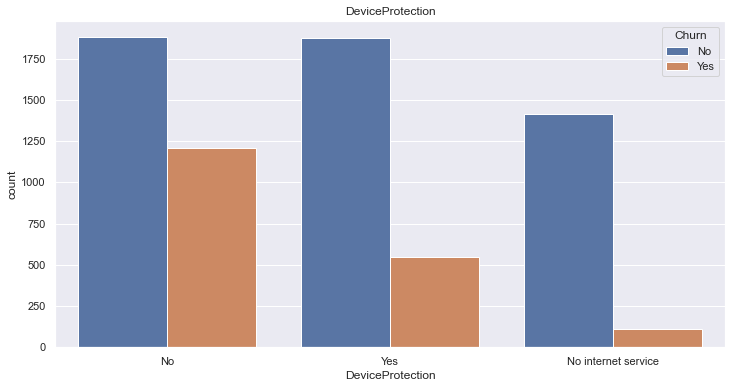

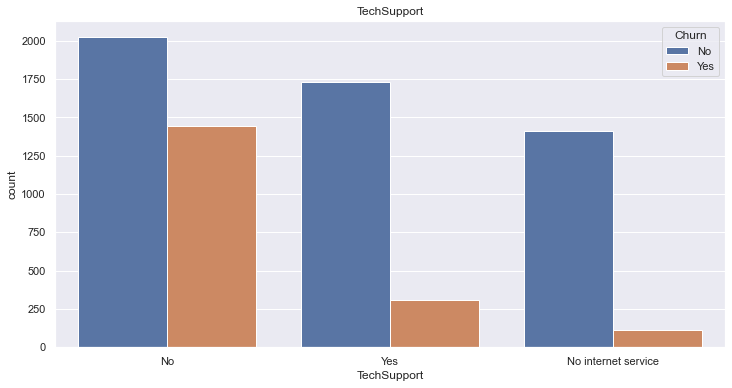

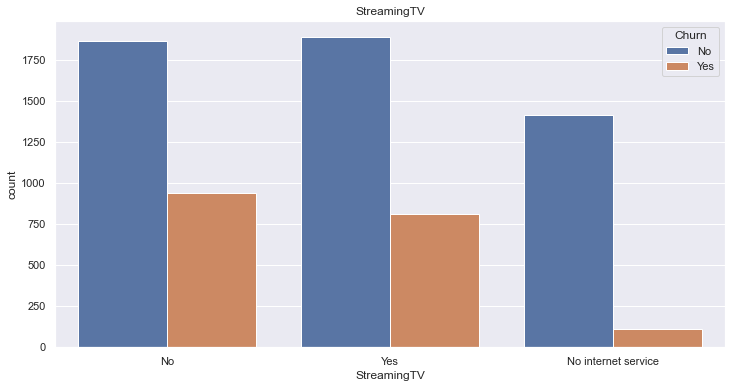

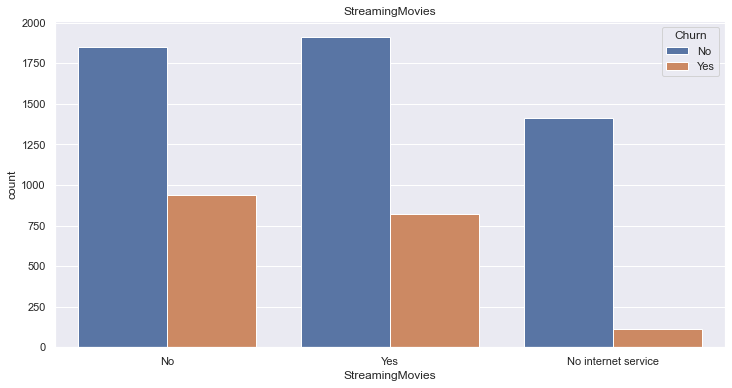

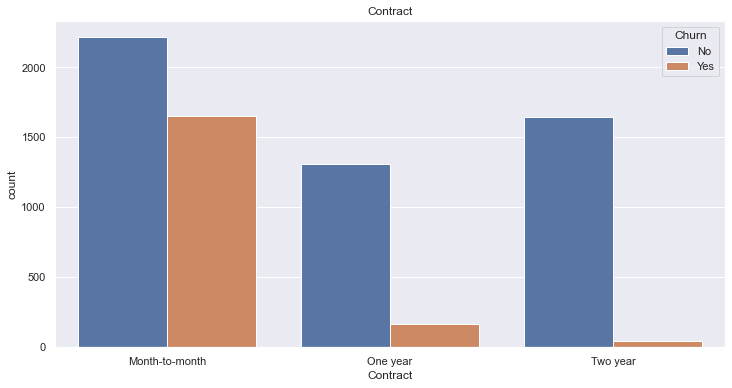

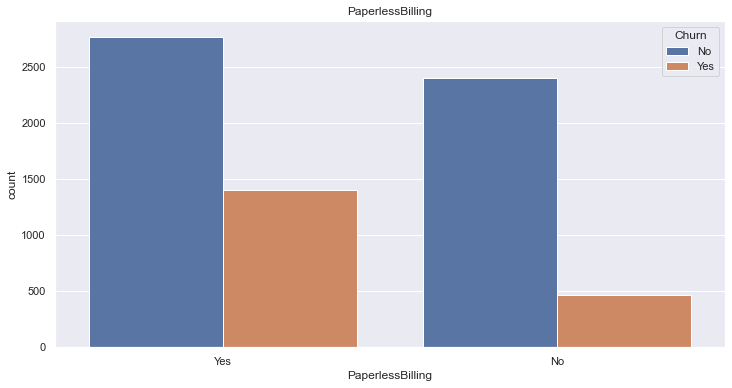

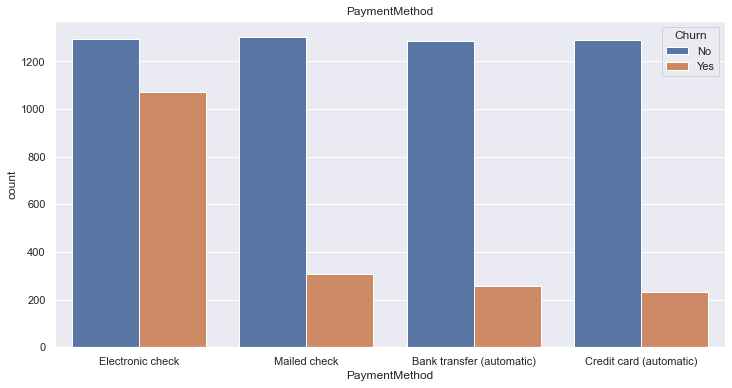

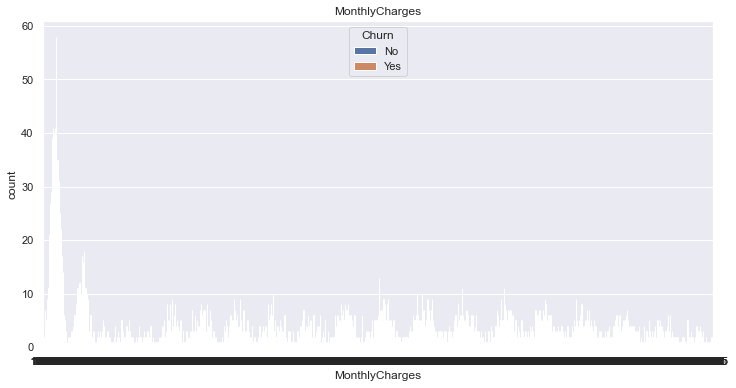

<Figure size 432x288 with 0 Axes>

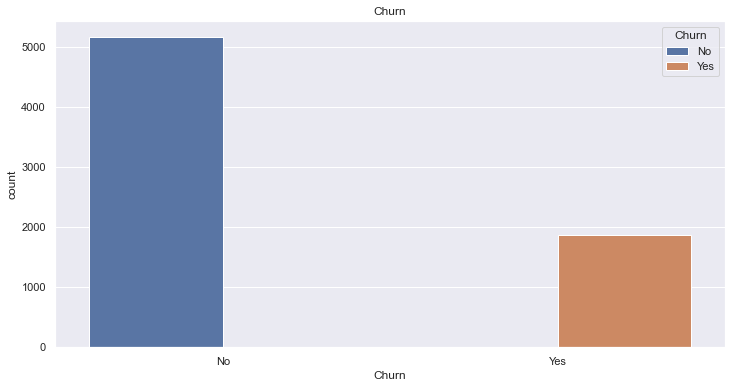

In [17]:
for index,col in enumerate(df.columns):
    if((col!="TotalCharges") & (col!="tenure")):
        plt.figure(index)
        plt.figure(figsize=(12,6))
        sns.countplot(x=col,hue="Churn",data=df)
        plt.title(col)
plt.show()

# Data Cleaning

In [18]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
#check for null values
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [20]:
df["TotalCharges"].fillna(df["TotalCharges"].median(),inplace=True)

In [21]:
df.isnull().sum().sum()

0

In [22]:
cat_features=list(df.select_dtypes(include=["object"]).columns)
encoder=LabelEncoder()
for feature in cat_features:
    df[feature]=encoder.fit_transform(df[feature])

In [23]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


<AxesSubplot:>

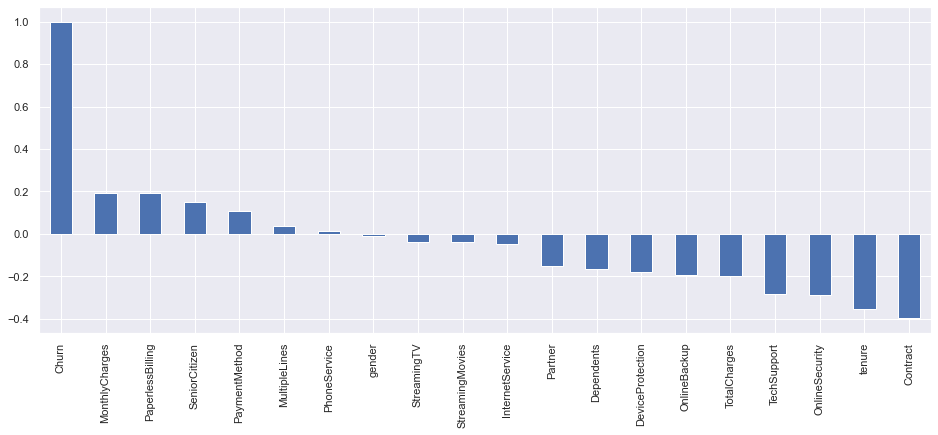

In [24]:
#get correlation of churn with other variables
plt.figure(figsize=(16,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")

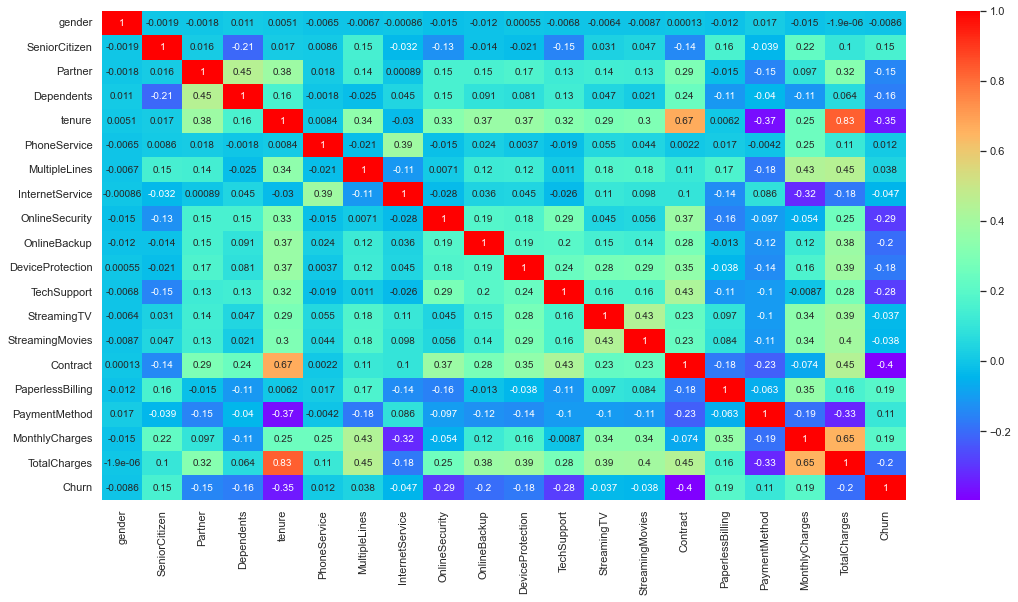

In [25]:
plt.figure(figsize=(18,9))
sns.heatmap(df.corr(),annot=True,cmap="rainbow")
plt.show()

since we are using ensemble methods for model building so there is no need of feature scaling as its prediction is based on creating multiple decision tree

In [26]:
#seperating independent variables and target variable
x=df.drop("Churn",axis=1)
y=df["Churn"]

In [27]:
x.shape

(7043, 19)

# Feature Selection
selecting only 10 features which has higher correlation with churn

In [28]:
select_feature=SelectKBest(k=10) #no of features to be select
select_feature.fit(x,y)

SelectKBest()

In [29]:
#Top 10 high correlated features
select_feature.get_feature_names_out()

array(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

In [30]:
x=x[select_feature.get_feature_names_out()]

In [31]:
#export selected features data into csv file
x.to_csv("selected_features.csv")

according to the feature selection we have selected 10 top features out of 19 features

split data into training and validation set in 80:20 ratio

In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [33]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((5634, 10), (5634,), (1409, 10), (1409,))

In [34]:
#its imbalance dataset
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [35]:
def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    #print("Training Accurary : ",model.score(x_train,y_train))
    print("Validation Accurary : ",accuracy_score(y_test,prediction))
    print("Precision Score : ",precision_score(y_test,prediction))
    print("Recall Score : ",recall_score(y_test,prediction))
    print("F1 Score : ",f1_score(y_test,prediction))
    print(classification_report(y_test,prediction))

In [36]:
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression()

In [37]:
#evaluate logistic regression model
evaluate_model_performance(log_reg,x_test)

Validation Accurary :  0.8112136266855926
Precision Score :  0.6656346749226006
Recall Score :  0.5764075067024129
F1 Score :  0.617816091954023
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.67      0.58      0.62       373

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.81      0.81      1409



In [38]:
#Random Forest Model
rand_forest=RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
rand_forest.fit(x_train,y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, min_samples_split=5,
                       n_estimators=120)

In [39]:
evaluate_model_performance(rand_forest,x_test)

Validation Accurary :  0.8119233498935415
Precision Score :  0.6942446043165468
Recall Score :  0.517426273458445
F1 Score :  0.5929339477726575
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [40]:
#Decison Tree Model
cart=DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_leaf=15)
cart.fit(x_train,y_train)

DecisionTreeClassifier(min_samples_leaf=15)

In [41]:
#evaluate decision tree model
evaluate_model_performance(cart,x_test)

Validation Accurary :  0.7721788502484032
Precision Score :  0.5838709677419355
Recall Score :  0.48525469168900803
F1 Score :  0.5300146412884333
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1036
           1       0.58      0.49      0.53       373

    accuracy                           0.77      1409
   macro avg       0.70      0.68      0.69      1409
weighted avg       0.76      0.77      0.77      1409



as we can observe our model is not performing up to the mark because of imbalance nature of dataset so we will balance it to reduce TN,FN and increase TP,FP

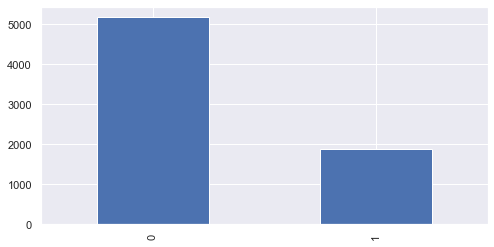

In [42]:
plt.figure(figsize=(8,4))
y.value_counts().plot(kind="bar")
plt.show()

In [43]:
smote=SMOTEENN()
x_st,y_st=smote.fit_resample(x,y)

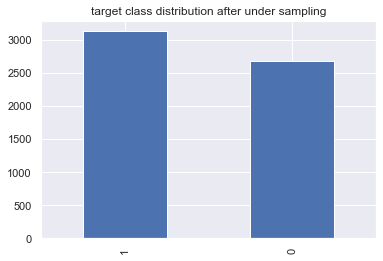

In [44]:
y_st.value_counts().plot(kind="bar")
plt.title("target class distribution after under sampling")
plt.show()

since we have performed under sampling method we can see our dataset is nearly balanced

In [45]:
#now split training and validation set using balanced dataset
x_train,x_test,y_train,y_test=train_test_split(x_st,y_st,test_size=0.2,random_state=42)

In [46]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((4648, 10), (4648,), (1162, 10), (1162,))

In [47]:
cart1=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
cart1.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=15, random_state=100)

In [48]:
#evaluate decison tree classifier 
evaluate_model_performance(cart1,x_test)

Validation Accurary :  0.9242685025817556
Precision Score :  0.921311475409836
Recall Score :  0.9335548172757475
F1 Score :  0.9273927392739273
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       560
           1       0.92      0.93      0.93       602

    accuracy                           0.92      1162
   macro avg       0.92      0.92      0.92      1162
weighted avg       0.92      0.92      0.92      1162



In [49]:
rfc=RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, min_samples_split=6,
                       n_estimators=150)

In [50]:
#evaluate Random Forest Classifier 
evaluate_model_performance(rfc,x_test)

Validation Accurary :  0.9345955249569707
Precision Score :  0.926948051948052
Recall Score :  0.9485049833887044
F1 Score :  0.9376026272577996
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       560
           1       0.93      0.95      0.94       602

    accuracy                           0.93      1162
   macro avg       0.94      0.93      0.93      1162
weighted avg       0.93      0.93      0.93      1162



In [51]:
lr_model=LogisticRegression(C=10, max_iter=150)
lr_model.fit(x_train,y_train)

LogisticRegression(C=10, max_iter=150)

In [52]:
#evaluate logistic regression model
evaluate_model_performance(lr_model,x_test)

Validation Accurary :  0.9165232358003442
Precision Score :  0.9105691056910569
Recall Score :  0.9302325581395349
F1 Score :  0.9202958093672966
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       560
           1       0.91      0.93      0.92       602

    accuracy                           0.92      1162
   macro avg       0.92      0.92      0.92      1162
weighted avg       0.92      0.92      0.92      1162



In [53]:
#GradientBoostingClassifier
gcb=GradientBoostingClassifier()
gcb.fit(x_train,y_train)

GradientBoostingClassifier()

In [54]:
#Evaluate GradientBoostingClassifier 
evaluate_model_performance(gcb,x_test)

Validation Accurary :  0.9311531841652324
Precision Score :  0.9264705882352942
Recall Score :  0.9418604651162791
F1 Score :  0.9341021416803954
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       560
           1       0.93      0.94      0.93       602

    accuracy                           0.93      1162
   macro avg       0.93      0.93      0.93      1162
weighted avg       0.93      0.93      0.93      1162



After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From this results we get bet accuracy and TP FP ratio also increases in GradientBoostClassifier so perform HyperParameter Tunning for this model only

In [55]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [56]:
gcb_optm=RandomizedSearchCV(estimator=gcb,param_distributions=param_grid,n_iter=100,verbose=1)
gcb_optm.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 6, 8, 9, 12, 15,
                                                           18, 24],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=1)

In [57]:
#evaluate performance of GradientBoostingClassifer with RandomSearchCV
evaluate_model_performance(gcb_optm,x_test)

Validation Accurary :  0.959552495697074
Precision Score :  0.9556650246305419
Recall Score :  0.9667774086378738
F1 Score :  0.9611890999174236
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       560
           1       0.96      0.97      0.96       602

    accuracy                           0.96      1162
   macro avg       0.96      0.96      0.96      1162
weighted avg       0.96      0.96      0.96      1162



In [58]:
gcb_optm.best_params_

{'n_estimators': 300,
 'min_samples_split': 3,
 'min_samples_leaf': 11,
 'max_leaf_nodes': 18,
 'max_depth': 19,
 'loss': 'deviance',
 'learning_rate': 0.5,
 'criterion': 'friedman_mse'}

In [59]:
final_model=gcb_optm.best_estimator_

In [60]:
#evaluate final GradientBoostingClassifier Performance
evaluate_model_performance(final_model,x_test)

Validation Accurary :  0.959552495697074
Precision Score :  0.9556650246305419
Recall Score :  0.9667774086378738
F1 Score :  0.9611890999174236
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       560
           1       0.96      0.97      0.96       602

    accuracy                           0.96      1162
   macro avg       0.96      0.96      0.96      1162
weighted avg       0.96      0.96      0.96      1162



Save Final Model Integration with application

In [61]:
file=open("trained_model.pkl","wb")
pickle.dump(final_model,file)
file.close()